In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

In [2]:
# Data management
# ==============================================================================
import numpy as np
import pandas as pd
from datetime import datetime

# Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

# Load preprocessed data
# ==============================================================================
url = "https://drive.google.com/file/d/1fMsYjfhrFLmeFjKG3jenXjDa5s984ThC/view?usp=sharing"
file_id = url.split('/')[-2]
url = 'https://drive.google.com/uc?id=' + file_id
data = pd.read_parquet(url)
print("Data shape:", data.shape)


In [5]:
# Fill missing values of air_temperature and wind_speed using fowrard and backward fill
# ==============================================================================
# Imputation must be done separately for each building
data = data.sort_values(by=['building_id', 'timestamp'])
data['air_temperature'] = data.groupby('building_id')['air_temperature'].ffill().bfill()
data['wind_speed'] = data.groupby('building_id')['wind_speed'].ffill().bfill()
data = data.sort_index()

print(
    f"Rage of dates available : {data.index.min()} --- {data.index.max()}  "
    f"(n_days={(data.index.max() - data.index.min()).days})"
)

Rage of dates available : 2016-01-01 00:00:00 --- 2016-12-31 00:00:00  (n_days=365)


In [8]:
# Split data in train, validation and test
# ==============================================================================
end_train = '2016-07-31 23:59:00'
end_validation = '2016-09-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(
    f"Rage of dates available : {data.index.min()} --- {data.index.max()} "
    f"(n_days={(data.index.max() - data.index.min()).days})"
)
print(
    f"  Dates for training    : {data_train.index.min()} --- {data_train.index.max()} "
    f"(n_days={(data_train.index.max() - data_train.index.min()).days})"
)
print(
    f"  Dates for validation  : {data_val.index.min()} --- {data_val.index.max()} "
    f"(n_days={(data_val.index.max() - data_val.index.min()).days})"
)
print(
    f"  Dates for test        : {data_test.index.min()} --- {data_test.index.max()} "
    f"(n_days={(data_test.index.max() - data_test.index.min()).days})"
)

Rage of dates available : 2016-01-01 00:00:00 --- 2016-12-31 00:00:00 (n_days=365)
  Dates for training    : 2016-01-01 00:00:00 --- 2016-07-31 00:00:00 (n_days=212)
  Dates for validation  : 2016-08-01 00:00:00 --- 2016-09-30 00:00:00 (n_days=60)
  Dates for test        : 2016-10-01 00:00:00 --- 2016-12-31 00:00:00 (n_days=91)


In [9]:
# Function to add calendar features to a DataFrame
# ==============================================================================
def day_of_week_cyclical_encoding(data):
    """
    Calculate cyclical encoding for the day of week using a 
    DataFrame with a datetime index.
    """
    data['day_of_week'] = data.index.dayofweek
    data['sin_day_of_week'] = np.sin(2*np.pi*data['day_of_week']/7)
    data['cos_day_of_week'] = np.cos(2*np.pi*data['day_of_week']/7)
    
    return data

# Exogenous Variables
# ==============================================================================
exog_features = ['sin_day_of_week', 'cos_day_of_week', 'air_temperature', 'wind_speed']

# Reshape data to have one column per building
# ==============================================================================
data_pivot = data.pivot_table(
                 index    = 'timestamp',
                 columns  = 'building_id',
                 values   = 'meter_reading',
                 aggfunc  = 'mean' 
             )
data_pivot.columns = data_pivot.columns.astype(str)
data_pivot = data_pivot.asfreq('D').sort_index()

# Add calendar features
data_pivot = day_of_week_cyclical_encoding(data_pivot)

# Add temperature and wind speed as exogenous variables
data_pivot = data_pivot.merge(
                 data[['air_temperature', 'wind_speed']].resample('D').mean(),
                 left_index  = True,
                 right_index = True,
                 how         = 'left',
                 validate    = '1:m'
             )

data_pivot.head(3)

<Axes: xlabel='timestamp'>

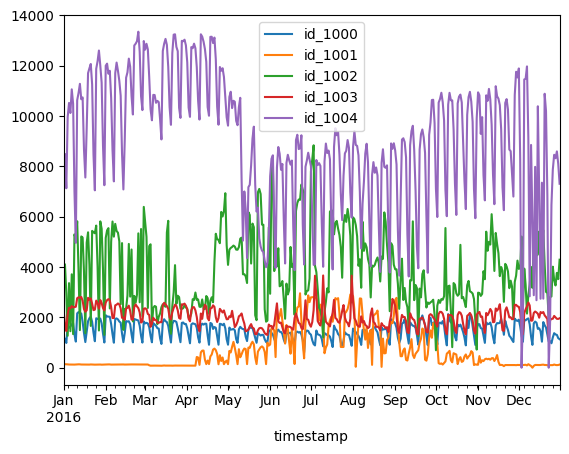

In [17]:
selected_buildings = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']
sample_data = data_pivot[selected_buildings].copy()
sample_data.plot()